In [289]:
import os 
import glob
import pandas as pd

import cv2
import numpy as np
#Img Augment

#import imgaug as ia
#import imgaug.augmenters as iaa
#from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn
from torch.utils.data import Dataset

from torchsummary import summary

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as T
from sklearn import preprocessing


import matplotlib.patches as patches
import matplotlib.pyplot as plt


from dataload import xml_to_csv,PetData

from tqdm import tqdm


In [348]:
##Loading data
root_path="D:/Dataset/Pet_Data/"
img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))
train, test = train_test_split(balanced_df, test_size=0.2,random_state=seed)

BATCH_SIZE = 1
train_ds = PetData(train, train=True)
valid_ds= PetData(test, train=True)
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

In [335]:
from collections import Counter
print(Counter(train.target))
from collections import Counter
print(Counter(test.target))

Counter({1: 958, 0: 942})
Counter({0: 246, 1: 230})


## Model Workflow
How R-CNN works can be summarized as follows:

1. *Pre-train a CNN* network on image classification tasks; for example, VGG or ResNet trained on ImageNet dataset. The classification task involves N classes.
    NOTE: You can find a pre-trained AlexNet in Caffe Model Zoo. I don’t think you can find it in Tensorflow, but Tensorflow-slim model library provides pre-trained ResNet, VGG, and others.

2. Propose category-independent regions of interest by selective search (~2k candidates per image). Those regions may contain target objects and they are of different sizes.
3. Region candidates are warped to have a fixed size as required by CNN.
4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.
5. Given every image region, one forward propagation through the CNN generates a feature vector. This feature vector is then consumed by a binary SVM trained for each class independently.
6. The positive samples are proposed regions with IoU (intersection over union) overlap threshold >= 0.3, and negative samples are irrelevant others.
To reduce the localization errors, a regression model is trained to correct the predicted detection window on bounding box correction offset using CNN features.

## 1. Pretrain a CNN network on image classification

In [336]:
import torch
from torchvision import models

#We used pretrained network from torch
mobilenet = models.mobilenet_v2(pretrained=True)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(mobilenet)}')


Num of parameters: 3504872


## 2. Selective Search from [AlpacaDB](https://github.com/AlpacaDB/selectivesearch)
### In actual R-CNN, they extracted 2k proposals but let's skip this detail...
Explanation to be added

In [337]:
from utills import ssearch,misc

In [338]:
img_lbl, regions = ssearch.selective_search(train_ds[0][0].numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)
print(f"Possibled Regions:{len(regions)}")

Possibled Regions:970


### Visualizing proposed regions

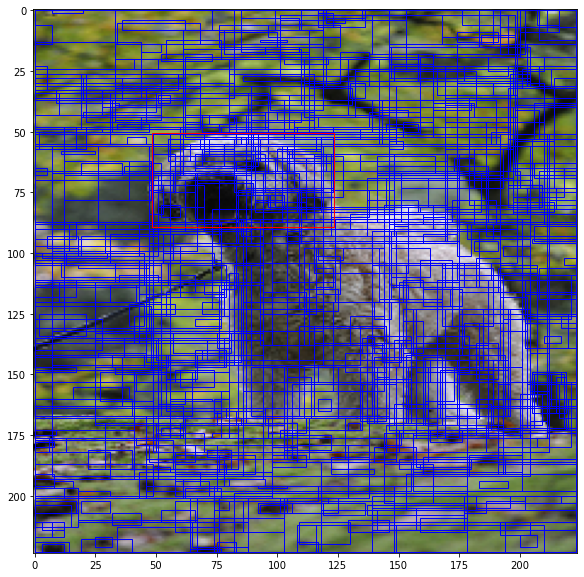

In [339]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_lbl[:,:,0:3]*0.5+0.5)
for i in regions:
    rect=i['rect']
    xy=rect[0],rect[1]
    width=rect[2]
    height=rect[3]
    
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False ) )
for bbox in train_ds[0][1]:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]

    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'red',
        fill=False ) )
plt.show()

## 3. Region candidates are warped to have a fixed size as required by CNN
## 4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.

In [340]:
def create_label(proposed_regions,bboxes):
    ''' 
    Adding Labelling to the proposed regions, if iou of prposed_region and actual bounding box of label 'x' is larger than the threshold, we label it as 'x' 
    
    proposed_regions:output of selective_search
    bboxes: ground truth bbox of original img
    '''
    from metrics import iou
    iou_threshold=0.5
    for region in proposed_regions:
        max_iou=0
        region['labels']=-1
        region_tensor=torch.tensor((region['rect'][0],region['rect'][1],region['rect'][0]+region['rect'][2],region['rect'][1]+region['rect'][3]))
        for bbox in bboxes:
            box_tensor=torch.tensor((bbox[0],bbox[1],bbox[2],bbox[3]))
            cur_iou=iou.torch_getIOU(region_tensor,box_tensor)
            if cur_iou>max_iou:
                max_iou=cur_iou
                if max_iou>iou_threshold:
                    region['labels']=bbox[4].item()    
                
        #region['iou']=max_iou
    return proposed_regions

def balance_df(proposed_regions):
    '''
    Rather than we oversample, we tried undersampling the background cases,  
    (*this is only for possible for this dataset which always and only have one of its classes (dog,cat) in the image)
    '''
    regions_df=pd.DataFrame.from_dict(proposed_regions)
    g = regions_df.groupby('labels')
    g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
    return g

In [341]:
import random
while True:
    idx=random.randint(0,len(train_ds)-1)
    data=train_ds[idx][0]
    img_lbl, regions = ssearch.selective_search(data.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)
    regions=create_label(regions,train_ds[0][1])
    pre_length=len(regions)
    regions=balance_df(regions)
    post_length=(len(regions))
    if pre_length !=post_length:
        break
print(f'Before Undersampling num of regions: {pre_length}')

print(f'After Undersampling num of regions: {post_length}')
        
print('Half is backgruond half is foreground')

Before Undersampling num of regions: 855
After Undersampling num of regions: 6
Half is backgruond half is foreground


In [342]:
#We create another dataset class to be used in training which stores the proposed region dataset
class Sub_region(Dataset):
    def __init__(self, df,img):
        self.src_img=img
        self.df=df
        self.resize=nn.Upsample((224,224))
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        label=self.df.iloc[idx]['labels']
        rect=self.df.iloc[idx]['rect']
        x1=rect[0]
        y1=rect[1]
        x2=rect[2]+x1+1
        y2=rect[3]+y1+1
        img=self.resize(self.src_img[:,y1:y2,x1:x2].unsqueeze(0))
        return img.squeeze(0),label
region_ds=Sub_region(regions,train_ds[0][0])
regions_dl =torch.utils.data.DataLoader(region_ds, batch_size=16,shuffle=True)
                                       

In [343]:
# [-1: background 0: cat, 1: dog]

le = preprocessing.LabelEncoder()
le.fit([-1,0,1])

actual_label=le.transform([-1,0,1])
print(actual_label)

[0 1 2]


[0 0 2 2 0 2]


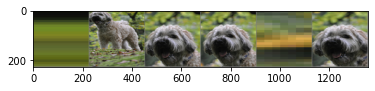

In [344]:


for batch_idx,(img,label) in enumerate(regions_dl):    
    plt.figure()
    actual_label=le.transform(label)
    print(actual_label)
    grid = make_grid(img, nrow=16)
    plt.imshow(grid.permute(1, 2, 0)*0.5+0.5)

In [271]:
## Finetuning 

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1]=nn.Linear(1280,3)
#freeze_some_part
for param in mobilenet.features[0:16].parameters():
    param.requires_grad = False
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(mobilenet)}')


Num of parameters: 1209923


In [345]:
import torch.optim as optim
device='cuda'
mobilenet.to(device)
epochs=50
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(mobilenet.parameters(),lr=5e-4) #Using small learning Rate

In [314]:
len(valid_dl)

476

In [358]:
avg_tloss_pimage_list=[]
avg_vloss_pimage_list=[]
for epoch in range(epochs):
    print(f'---------\n Epoch: {epoch} \n---------\n ')
    mobilenet.train()
    total_tloss=0
    avg_acc_regions=None
    for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(train_dl)):
        acc_regions=None
        for img,bbox in zip(img_tuple,bbox_tuple):  
            
            #Current selective search only works for one_single,
            #so batch_size of original dataset is 1... 
            #which means tuple has only length of 1
            
            #regions proposal
            img_lbl, regions = ssearch.selective_search(img.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)

            regions=create_label(regions,bbox)
            pre_length=len(regions)
            
            #balancing regions labels
            regions=balance_df(regions)
            post_length=(len(regions))

            #If no true ground_true region is proposed we skip
            if pre_length ==post_length: 
                break
            acc_regions=0
            
            #Create Dataset of proposed regions
            region_ds=Sub_region(regions,img)
            regions_dl =torch.utils.data.DataLoader(region_ds, batch_size=8,shuffle=True)
            
            #Train over regions
            total=0
            correct = 0

            for region_batch_idx,(region_img,label) in enumerate(regions_dl):
                optimizer.zero_grad()
                label=le.transform(label)
                label=torch.LongTensor(label).to(device)
                region_img=region_img.to(device)
                out_clss=mobilenet(region_img)
                loss=criterion(out_clss,label)
                loss.backward()
                avg_tloss_pimage+=loss.item()
                optimizer.step()
                _, predicted = torch.max(out_clss, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

            acc_regions=(100 * correct / total)
            
        if img_batch_idx %200==0:
            print(f"Average Img Train_Loss: {avg_tloss_pimage/len(regions_dl)}")
            if acc_regions is not None:
                print(f"Average Img Train_Acc: {acc_regions/(img_batch_idx+1)}")
                
        avg_tloss_pimage_list.append(avg_tloss_pimage/len(regions_dl))
        break
        
    #Evaluation on the valid_dataset
    mobilenet.eval()
    avg_total_valid_loss=0
    for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(valid_dl)):
        avg_vloss_pimage=0
        avg_acc_regions=0
        for img,bbox in zip(img_tuple,bbox_tuple):  

            img_lbl, regions = ssearch.selective_search(img.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)
            regions=create_label(regions,bbox)
            pre_length=len(regions)
            regions=balance_df(regions)
            post_length=(len(regions))

            if pre_length ==post_length:  #If no true ground_true region is proposed we skip
                break
                
            region_ds=Sub_region(regions,img)
            regions_dl =torch.utils.data.DataLoader(region_ds, batch_size=8,shuffle=True)

            total=0
            correct = 0

            for region_batch_idx,(region_img,label) in enumerate(regions_dl):
                label=le.transform(label)
                label=torch.LongTensor(label).to(device)
                region_img=region_img.to(device)
                out_clss=mobilenet(region_img)
                avg_vloss_pimage+=loss.item()
                _, predicted = torch.max(out_clss, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
            
            avg_acc_regions+=(100 * correct / total)            
            
        avg_vloss_pimage=avg_vloss_pimage/len(regions_dl)
        avg_total_valid_loss+=avg_vloss_pimage
        break
    print(f'Average Valid_loss: {avg_total_valid_loss/(img_batch_idx+1)}')
    print(f'Average Valid_Acc: {avg_acc_regions/(img_batch_idx+1)}')
        
    avg_vloss_pimage_list.append(avg_total_valid_loss/(img_batch_idx+1))
    torch.save({
            'epoch': epoch,
            'model_state_dict': mobilenet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'tloss_list': avg_tloss_pimage_list,
            'vloss_list': avg_vloss_pimage_list,
            }, f"D:/model_save/mobilenet_{epoch}.pt")

0it [00:00, ?it/s]

---------
 Epoch: 0 
---------
 


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 77.12598694860935
Average Img Train_Acc: 90.0


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Valid_loss: f0.022089719772338867
Average Valid_Acc: f50.0
---------
 Epoch: 1 
---------
 


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 77.12598694860935


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Valid_loss: f0.022089719772338867
Average Valid_Acc: f50.0
---------
 Epoch: 2 
---------
 


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 82.83695782721043
Average Img Train_Acc: 50.0


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Valid_loss: f5.551858425140381
Average Valid_Acc: f50.0
---------
 Epoch: 3 
---------
 


0it [00:02, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 21.76131476296319
Average Img Train_Acc: 48.57142857142857


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Valid_loss: f0.46803173422813416
Average Valid_Acc: f50.0
---------
 Epoch: 4 
---------
 


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 97.92591643333435


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Valid_loss: f0.46803173422813416
Average Valid_Acc: f50.0
---------
 Epoch: 5 
---------
 


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 97.92591643333435


0it [00:01, ?it/s]
0it [00:00, ?it/s]

Average Valid_loss: f0.46803173422813416
Average Valid_Acc: f50.0
---------
 Epoch: 6 
---------
 


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Average Img Train_Loss: 97.92591643333435


KeyboardInterrupt: 